Harshani Rathnayake

Project 3: Python Code

In [19]:
#Import required libraries
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

#GridWorld Environment and Learning Optimal Policies

This notebook implements and compares Q-Learning and SARSA algorithms on a simple GridWorld problem.  
We visualize learned policies, compare agent trajectories, and analyze cumulative rewards to understand the differences between these two classic reinforcement learning approaches.


In [20]:
#Define GridWorld environment
class GridWorld:
    #GridWorld environment simulating a 5x5 grid with special states and rewards:
    #- Grid size: 5 rows x 5 columns
    #- Start state: blue square at coordinates (4, 0) (bottom-left corner)
    #- Red states: stepping on any of these cells results in a penalty (-20 reward) and the agent is reset back to the start state
    #- Black states: terminal states where the episode ends with 0 reward
    #- Moving to any other valid state costs -1 reward per move

    def __init__(self):
        #Size of the grid world (5x5)
        self.grid_size = 5
        #Starting position of the agent (row 4, column 0)
        self.start_state = (4, 0)
        #Black states represent terminal states; reaching these ends the episode
        self.black_states = [(0, 0), (0, 4)]
        #Red states are 'dangerous' states with heavy penalty and reset to start
        self.red_states = [(2, 0), (2, 1), (2, 3), (2, 4)]
        #Possible actions agent can take
        self.actions = ['up', 'down', 'left', 'right']
        #Initialize the current state to the start state
        self.state = self.start_state

    def reset(self):
        #Reset the environment to the initial start state.
        #Returns: tuple: The starting state coordinates (row, col)
        self.state = self.start_state  #Reset agent position to start
        return self.state

    def step(self, action):
        #Take an action in the environment and update the state.
        #Args:
            #action (str): The action to take ('up', 'down', 'left', 'right')
        #Returns:
            #next_state (tuple): The next state coordinates (row, col)
            #reward (int): The reward received after taking the action
            #done (bool): Whether the episode has ended (True if in terminal state)
        row, col = self.state  #Current position
        #Calculate new position based on action
        if action == 'up':
            row -= 1  #Move one row up
        elif action == 'down':
            row += 1  #Move one row down
        elif action == 'left':
            col -= 1  #Move one column left
        elif action == 'right':
            col += 1  #Move one column right

        #Checks if new position is outside grid boundaries
        if row < 0 or row >= self.grid_size or col < 0 or col >= self.grid_size:
            #Invalid move: outside grid, stay in current state and give -1 penalty
            reward = -1
            next_state = self.state
        else:
            #Valid move inside grid
            next_state = (row, col)
            #Check if stepped on red state: heavy penalty and reset to start
            if next_state in self.red_states:
                reward = -20
                next_state = self.start_state  # Reset position to start
            #Check if stepped on terminal black state: zero reward, end episode
            elif next_state in self.black_states:
                reward = 0
            else:
                #Normal step: small penalty to encourage faster completion
                reward = -1
        #Update the current state to the new position
        self.state = next_state
        #Episode ends if in terminal (black) state
        done = next_state in self.black_states
        return next_state, reward, done

## Defined Learning Algorithms:
Below, implements:
- Q-Learning (off-policy): learns the optimal action-value by using max future reward.
- SARSA (on-policy): updates using action actually taken.
Both use ε-greedy exploration.


In [21]:
def q_learning(env, episodes=500, alpha=0.1, gamma=0.99, epsilon=0.1):
    #Q-Learning algorithm for finding the optimal policy in a given environment
    #Args:
        #env: The environment object which supports reset() and step(action)
        #episodes (int): Number of episodes to run the training
        #alpha (float): Learning rate (step size for Q-value updates)
        #gamma (float): Discount factor for future rewards
        #epsilon (float): Exploration rate for epsilon-greedy policy
    #Returns:
        #q_table (dict): A nested dictionary mapping state -> action -> Q-value
        #rewards_per_episode (list): Cumulative reward obtained in each episode

    #Initialize Q-table with zeros for all states and actions
    #Keys: states (row, col), values: dictionary of actions and their Q-values initialized to 0.0
    q_table = {
        (row, col): {a: 0.0 for a in env.actions}
        for row in range(env.grid_size)
        for col in range(env.grid_size)
    }

    #List to store total reward received in each episode
    rewards_per_episode = []
    #Loop over the number of episodes to train the agent
    for _ in range(episodes):
        state = env.reset()  #Reset environment to starting state for new episode
        done = False  #Flag to indicate if episode has ended
        total_reward = 0  #Accumulate rewards within the episode
        #Loop until the episode ends (reaching terminal state)
        while not done:
            #ε-greedy action selection:
            #With probability epsilon, select a random action (explore)
            #Otherwise select action with highest Q-value in current state (exploit)
            if random.uniform(0, 1) < epsilon:
                action = random.choice(env.actions)  #Explore: random action
            else:
                #Find the maximum Q-value for the current state
                max_val = max(q_table[state].values())
                #List of all actions that have this maximum Q-value (handle ties)
                best_actions = [a for a, v in q_table[state].items() if v == max_val]
                #Select one best action at random (to break ties)
                action = random.choice(best_actions)

            #Take action in environment: get next state, reward, and done flag
            next_state, reward, done = env.step(action)
            #Find best next action to estimate max future reward
            best_next_action = max(q_table[next_state], key=q_table[next_state].get)
            #Q-Learning update rule:
            #Q(s, a) = Q(s, a) + alpha * [reward + gamma * max_a' Q(s', a') - Q(s, a)]
            q_table[state][action] += alpha * (
                reward + gamma * q_table[next_state][best_next_action] - q_table[state][action]
            )
            #Update state to next state for next iteration
            state = next_state
            #Accumulate reward obtained in this step
            total_reward += reward
        #Append total reward of the current episode to the list
        rewards_per_episode.append(total_reward)
    #After training, return the learned Q-table and rewards per episode
    return q_table, rewards_per_episode

In [22]:
def sarsa(env, episodes=500, alpha=0.1, gamma=0.99, epsilon=0.1):
    #SARSA algorithm for on-policy temporal-difference learning.
    #Args:
        #env: The environment object with reset() and step(action) methods.
        #episodes (int): Number of episodes to train.
        #alpha (float): Learning rate for Q-value updates.
        #gamma (float): Discount factor for future rewards.
        #epsilon (float): Exploration rate for epsilon-greedy policy.
    #Returns:
        #q_table (dict): Learned Q-values for each state-action pair.
        #rewards_per_episode (list): Total cumulative rewards collected per episode.

    #Initialize Q-table: keys are states, values are dicts mapping actions to Q-values initialized to 0.0
    q_table = {
        (row, col): {a: 0.0 for a in env.actions}
        for row in range(env.grid_size)
        for col in range(env.grid_size)
    }
    #List to track total reward per episode
    rewards_per_episode = []
    #Loop over each episode for training
    for _ in range(episodes):
        state = env.reset()  #Reset environment to start state
        #Choose initial action using epsilon-greedy policy
        if random.uniform(0, 1) < epsilon:
            action = random.choice(env.actions)  #Explore: random action
        else:
            max_val = max(q_table[state].values())
            best_actions = [a for a, v in q_table[state].items() if v == max_val]
            action = random.choice(best_actions)  #Exploit: choose best action (random tie-breaker)
        done = False  #Flag to mark episode completion
        total_reward = 0  #Track total reward for this episode
        #Continue until reaching terminal state
        while not done:
            #Take the chosen action, observe next state, reward, and whether done
            next_state, reward, done = env.step(action)
            #Choose next action from next state using epsilon-greedy policy (on-policy)
            if random.uniform(0, 1) < epsilon:
                next_action = random.choice(env.actions)  #Explore
            else:
                max_val = max(q_table[next_state].values())
                best_actions = [a for a, v in q_table[next_state].items() if v == max_val]
                next_action = random.choice(best_actions)  # Exploit
            #Update Q-value using SARSA update rule:
            #Q(s,a) = Q(s,a) + alpha * [reward + gamma * Q(s', a') - Q(s,a)]
            q_table[state][action] += alpha * (
                reward + gamma * q_table[next_state][next_action] - q_table[state][action]
            )
            #Move to the next state and next action for next step
            state, action = next_state, next_action
            #Accumulate reward received in this episode
            total_reward += reward
        #Append cumulative reward of this episode to the list
        rewards_per_episode.append(total_reward)
    #Return learned Q-table and reward history
    return q_table, rewards_per_episode

## Run both algorithms and visualize results
Both agents are trained and compared:
- Learned policies
- Trajectories following greedy policies
- Smoothed rewards over episodes


In [23]:
#Set random seeds for reproducibility
#This ensures that results are consistent across runs
random.seed(42)
np.random.seed(42)
#Initialize the GridWorld environment
env = GridWorld()
#Define the number of episodes to train the agents
episodes = 500
#Train Q-Learning agent on the environment
#Returns the learned Q-table and rewards per episode
q_table_q, rewards_q = q_learning(env, episodes)
#Train SARSA agent on the environment
#Returns the learned Q-table and rewards per episode
q_table_s, rewards_s = sarsa(env, episodes)

In [24]:
def get_trajectory(q_table, env, max_steps=50):
    #Generate a trajectory (sequence of states) by following the greedy policy derived from the Q-table
    #Args:
        #q_table (dict): Learned Q-values mapping state -> action -> value
        #env: Environment with reset() and step(action) methods
        #max_steps (int): Maximum number of steps to simulate to avoid infinite loops
    #Returns:
        #traj (list): List of states visited starting from initial state until terminal state or max_steps reached

    #Reset the environment to get the start state
    state = env.reset()
    #Initialize the trajectory list with the start state
    traj = [state]
    done = False  #Flag to indicate if terminal state reached
    steps = 0  #Step counter to limit trajectory length
    #Loop until episode ends or maximum steps reached
    while not done and steps < max_steps:
        #Find the maximum Q-value for the current state
        max_val = max(q_table[state].values())
        #Get all actions with the max Q-value (handle ties)
        best_actions = [a for a, v in q_table[state].items() if v == max_val]
        #Choose one of the best actions at random to break ties
        action = random.choice(best_actions)
        #Take the action and observe next state and whether done
        next_state, _, done = env.step(action)
        #Append the next state to the trajectory
        traj.append(next_state)
        #Update current state to the next state
        state = next_state
        #Increment the step count
        steps += 1
    return traj

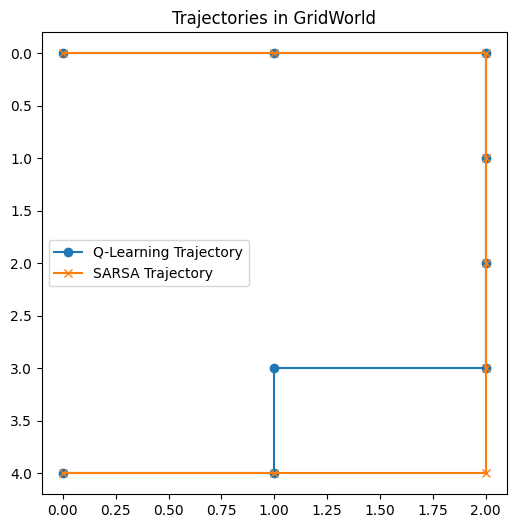

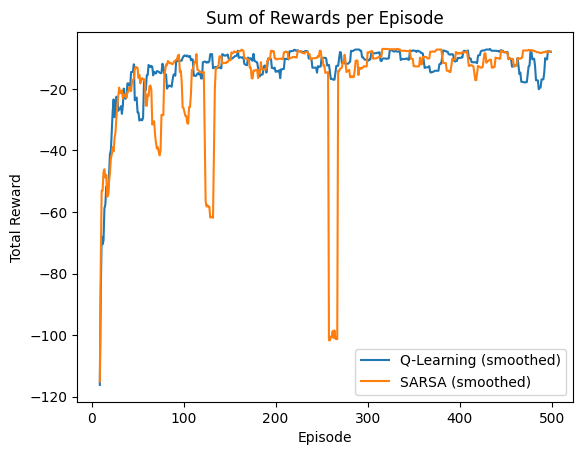

In [25]:
#Plot trajectories of learned policies for Q-Learning and SARSA
#Generate trajectory by following greedy policy from Q-Learning Q-table
traj_q = get_trajectory(q_table_q, env)
#Generate trajectory by following greedy policy from SARSA Q-table
traj_s = get_trajectory(q_table_s, env)
plt.figure(figsize=(6, 6))  #Set figure size to 6x6 inches
#Unpack states into separate coordinate lists (x = row, y = column) for Q-Learning trajectory
x, y = zip(*traj_q)
plt.plot(y, x, marker='o', label='Q-Learning Trajectory')
#Note: y is plotted on x-axis and x on y-axis to match grid orientation
#Unpack states for SARSA trajectory
x, y = zip(*traj_s)
plt.plot(y, x, marker='x', label='SARSA Trajectory')
plt.gca().invert_yaxis()  #Invert y-axis to align with grid row indexing (top row = 0)
plt.title('Trajectories in GridWorld')  #Title of the plot
plt.legend()  #Show legend for labels
plt.show()  #Display the plot

#Plot smoothed total rewards per episode for both algorithms
plt.figure()  #Create a new figure for the reward plot
#Use pandas Series with rolling window of 10 to smooth noisy reward signals
plt.plot(pd.Series(rewards_q).rolling(10).mean(), label='Q-Learning (smoothed)')
plt.plot(pd.Series(rewards_s).rolling(10).mean(), label='SARSA (smoothed)')
plt.xlabel('Episode')  #X-axis label
plt.ylabel('Total Reward')  #Y-axis label
plt.title('Sum of Rewards per Episode')  #Plot title
plt.legend()  #Show legend
plt.show()  #Display the plot


In [29]:
def print_policy(q_table, env):
    #Print the learned policy as a grid:
    #- 'S' for the start state
    #- 'P' for red penalty states
    #- 'B' for black terminal states
    #- U / D / L / R letters show the best action (Up, Down, Left, Right) in each other state

    grid = []  #List to hold each row of the printed policy
    #Loop over each row and column in the grid
    for row in range(env.grid_size):
        grid_row = []  #Temporary list to hold symbols for this row
        for col in range(env.grid_size):
            state = (row, col)  #Current state coordinates
            #Check for special states and assign symbol accordingly
            if state in env.red_states:
                grid_row.append('P')  #Red penalty state
            elif state in env.black_states:
                grid_row.append('B')  #Black terminal state
            elif state == env.start_state:
                grid_row.append('S')  #Start state
            else:
                #For normal states, find the best action from Q-table
                best_action = max(q_table[state], key=q_table[state].get)
                #Use first letter of action in uppercase (U/D/L/R)
                grid_row.append(best_action[0].upper())
        grid.append(grid_row)  #Add completed row to the grid
    #Print the grid row by row as a formatted string
    for row in grid:
        print(' '.join(row))

## Learned Policies:


In [30]:
#Print the policy learned by Q-Learning
print("Q-Learning Policy:")
print_policy(q_table_q, env)
#Print a blank line for separation
print("\nSARSA Policy:")
#Print the policy learned by SARSA
print_policy(q_table_s, env)

Q-Learning Policy:
B L L R B
U U U U U
P P U P P
R R U L D
S U U U D

SARSA Policy:
B L L R B
U U U U U
P P U P P
R R U L D
S R U L D
